We start with importing the libraries we need and setting the plot mode for inline display

Note: To run this Jupyter notebook on your local machine please ensure you have the following dependencies installed as a precondition:

cv2
imutils
matplotlib
ffmpeg

In [1]:
import base64
import cv2
import time
import imutils
import os
import numpy as np
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import HTML

%matplotlib inline

In this script we will be using some static configuration parameters, which we wouldn't normally require to change.

A special note for the parameter eotIn which is a special signature used to indicate the end of text.

This allows the extraction logic to stop processing the image when all the text has been extracted, hence saving time.

In [2]:
# define configuration params
figureSize = (12,10) # image size for display
displayWidth = (1024+128) # max width of image for display
maxDebugBytes = 10 # max num of bytes to view in debug mode
eotInd = 2730 # '101010101010' - 12 bit End-Of-Text indicator
maxCharRange = 127 # max range of characters as per ASCII table
debugMode = False # flag to view debug prints
visFps = 30 # frames per second for the captured visualization video
visStack = 0 # direction (0-horizontal/1-vertical) for visualization stack

Then we move on to define the core logic of our script, the Steganography class and it's member functions.

This class implements the insert and extract operations along with some utility functions.

In [3]:
class Steganography(object):

    @staticmethod
    def __int_to_bin(rgb):
        """Convert an integer tuple to a binary (string) tuple.

        :param rgb: An integer tuple (e.g. (220, 110, 96))
        :return: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        """
        r, g, b = rgb
        return ('{0:08b}'.format(r),
                '{0:08b}'.format(g),
                '{0:08b}'.format(b))

    @staticmethod
    def __bin_to_int(rgb):
        """Convert a binary (string) tuple to an integer tuple.

        :param rgb: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        :return: Return an int tuple (e.g. (220, 110, 96))
        """
        r, g, b = rgb
        return (int(r, 2),
                int(g, 2),
                int(b, 2))

    @staticmethod
    def __hide_rgb(rgb1, rgb2):
        """hide two RGB tuples.

        :param rgb1: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        :param rgb2: Another string tuple
        (e.g. ("00101010", "11101011", "00010110"))
        :return: An integer tuple with the two RGB values hidden.
        """
        r1, g1, b1 = rgb1
        r2, g2, b2 = rgb2
        rgb = (r1[:4] + r2[:4],
               g1[:4] + g2[:4],
               b1[:4] + b2[:4])
        return rgb

    @staticmethod
    def insert(imfile, txtfile, outputfile, debug=False):
        """Hide a text within an image.

        :param imfile: Input Image file
        :param txtfile: Input Text file
        :param outputfile: Output Image file
        :param debug: Flag for debug prints
        :return: True or False depending on Success or Failure of operation
        """
        # check is image path is valid
        if not os.path.exists(imfile):
          print("!! Unable to locate image file:",imfile)
          return False
        
        # check is text path is valid
        if not os.path.exists(txtfile):
          print("!! Unable to locate text file:",txtfile)
          return False

        # Load the image
        image = cv2.imread(imfile,cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # Clone the original image to create a copy that will contain hidden content
        new_image = image.copy()
        
        # check if image contains 3 channels, else quit
        im_shape = image.shape
        if len(im_shape) != 3:
          print("!! Unable to insert text as image does not have 3 channels !!")
          return False
        elif im_shape[2] != 3:
          print("!! Unable to insert text as image does not have 3 channels !!")
          return False
        
        # Open the text file and read the content
        fp = open(txtfile, 'rb')
        text_bin = fp.read()
        fp.close()

        print("Length of text: {} chars".format(len(text_bin)))
        
        # check if image size is sufficient to encode full text, else quit
        required_bytes = len(text_bin) * 3
        if required_bytes > im_shape[0] * im_shape[1] * 3:
          print("!! Unable to insert full text as image does not have sufficient size !!")
          return False
        
        # initialize variables
        idx = 0
        break_flag = False

        for i in range(im_shape[0]):
            for j in range(im_shape[1]):
                rgb1 = Steganography.__int_to_bin(image[i,j])
                
                if idx == len(text_bin):
                  # if no more text left to insert, add the end of text signature
                  bin_val = "{0:012b}".format(eotInd)
                  break_flag = True
                  if debug:
                    print("Hit end of text at idx:",idx)
                    print("No of bytes used:", idx*3)
                else:
                  if text_bin[idx] > maxCharRange:
                    # if character is out of max range, insert a 'dot' character in 12-bit binary format
                    bin_val = "{0:012b}".format(ord('.'))
                  else:
                    # convert character to 12-bit binary format
                    bin_val = "{0:012b}".format(text_bin[idx])
                  
                # split into 3 channels of 4 bits each
                rgb2 = (bin_val[:4],bin_val[4:8],bin_val[8:12])

                # hide the two pixels and convert it to a integer tuple
                rgb = Steganography.__hide_rgb(rgb1, rgb2)

                new_image[i,j] = Steganography.__bin_to_int(rgb)
                
                if debug:
                  if idx < maxDebugBytes:
                    # visualize first maxDebugBytes
                    # print(text_bin[idx])
                    # print(chr(text_bin[idx]))
                    print("bin_val[{}]:{}".format(idx,bin_val))
                
                idx += 1
                if break_flag == True:
                  break
            if break_flag == True:
              break

        plt.figure(figsize=figureSize)
        plt.imshow(imutils.resize(image,width=displayWidth))
        plt.title('Original Image')
        plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
        plt.show()
        
        plt.figure(figsize=figureSize)
        plt.imshow(imutils.resize(new_image,width=displayWidth))
        plt.title('Image with Hidden Text')
        plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
        plt.show()
        
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
        
        if os.path.exists(outputfile):
            os.remove(outputfile)
            
        cv2.imwrite(outputfile,new_image)

        return True

    @staticmethod
    def extract(imfile, txtfile, visualize, visfile, debug=False):
        """Extract hidden text from an image.

        :param imfile: input image file containing hidden text
        :param txtfile: output text file containing extracted text
        :param visualize: flag to enable/disable visualization
        :param visfile: output file to store visualization video
        :param debug: Flag for debug prints
        :return: True or False depending on Success or Failure of operation.
        """

        # check is image path is valid
        if not os.path.exists(imfile):
          print("!! Unable to locate image file:",imfile)
          return False
        
        # Load the image
        image = cv2.imread(imfile,cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # Store the image size
        im_shape = image.shape
        # check if image contains 3 channels, else quit
        if len(im_shape) != 3:
          print("!! Unable to extract text as image does not have 3 channels !!")
          return False
        elif im_shape[2] != 3:
          print("!! Unable to extract text as image does not have 3 channels !!")
          return False
        
        # initialize variables
        text_bin = []
        idx = 0
        break_flag = False

        # create a canvas for displaying extracted text
        text_canvas =  np.zeros_like(image)
        # create a white canvas for displaying image
        white_canvas =  255 * np.ones_like(image)
        
        if visualize.lower() == 'true':
            vis_width = displayWidth
            vis_height = int(0.5*displayWidth*im_shape[0]/im_shape[1])
            visframes = []
            capture_vis = True
        else:
            capture_vis = False
            
        print("Begin processing image file... this may take a few minutes")
        start_time = time.time()
        for i in range(im_shape[0]):
            for j in range(im_shape[1]):
                # Get the RGB (as a string tuple) from the current pixel
                r, g, b = Steganography.__int_to_bin(image[i,j])

                # Extract the last 4 bits (corresponding to the hidden text)
                bin_val = r[4:] + g[4:] + b[4:]
                
                if debug:
                # view first maxDebugBytes bytes
                  if idx < maxDebugBytes:
                    print("bin_val[{}]:{}".format(idx,bin_val))

                # Convert it to an integer
                int_val = int(bin_val,2)
                if int_val == eotInd:
                  # Check if End-Of-Text indicator is found
                  if debug:
                    print("Found end of text signature at index:", idx)
                  break_flag = True
                elif int_val <= maxCharRange:
                  # only take characters within max range and append to output list
                  text_bin.append(int_val)

                  if capture_vis == True:
                    # visualize the extraction process
                    try:
                      xpos = (j*30) % im_shape[1]
                      ypos = i+30 + (j*30//im_shape[1]) * 30
                      
                      cv2.putText(text_canvas, chr(text_bin[idx]), (xpos,ypos),cv2.FONT_HERSHEY_SIMPLEX,1.0,(0, 255, 0),4)
                      
                      # create a canvas for displaying original image while extraction with some blurring effect
                      img_canvas = image.copy()
                      img_canvas = cv2.addWeighted(img_canvas, 0.30, white_canvas, 0.70, 0)
                      # show a small moving box to indicate pixel processing
                      rectx = (j*30) % im_shape[1]
                      recty = (i + (j*30//im_shape[1]) * 30) % im_shape[0]
                      rectw = 30
                      recth = 30
                      
                      cv2.rectangle(img_canvas, (rectx, recty), (rectx+rectw, recty+recth), (0,0,255), 5)
                      
                      if idx%20 < 10:
                        # Add a blinking text effect
                        cv2.putText(img_canvas, 'Scanning Image', (int(0.6* im_shape[1]//2),im_shape[0]//2),cv2.FONT_HERSHEY_SIMPLEX,3.0,(255, 0, 0), 10)
                      
                      if visStack == 0:
                        # stack_img = np.hstack((img_canvas,text_canvas))
                        stack_img = np.hstack((imutils.resize(img_canvas,width=displayWidth//2),imutils.resize(text_canvas,width=displayWidth//2)))
                      else:
                        # stack_img = np.vstack((img_canvas,text_canvas))
                        stack_img = np.vstack((imutils.resize(img_canvas,width=displayWidth//2),imutils.resize(text_canvas,width=displayWidth//2)))

                      stack_img = cv2.cvtColor(stack_img, cv2.COLOR_RGB2BGR)
                      visframes.append(stack_img)
                        
                      if ypos >= im_shape[0]:
                        capture_vis = False
                      
                    except Exception as err:
                        print("!! Visualization error:", err)
                        visualize = 'false'
                        capture_vis = False
                  
                  idx += 1
                  
                if break_flag == True:
                  break
            if break_flag == True:
              break

        end_time = time.time()
        print("Finished processing image file... time taken: {:0.02f}s".format(end_time-start_time))
        
        if visualize.lower() == 'true':
            print('Begin saving visualization file... this may take a few minutes')
            start_time = time.time()
            delay = 1000 / visFps
            num_frames = len(visframes)

            fig = plt.figure(figsize=(vis_width/100, vis_height/100), tight_layout=True)
            im = plt.imshow(visframes[0])
            plt.axis('off')
            plt.grid(visible=False)


            def update_vis(i):
              """Updates the visualization"""
              im.set_data(visframes[i])

            anim = FuncAnimation(
                    fig,
                    update_vis,
                    frames=np.arange(1, num_frames),
                    interval=delay,
                    blit=False)
            
            if os.path.exists(visfile):
                os.remove(visfile)
            
            if visfile[-3:] == 'gif':
              anim.save(visfile, dpi=100, fps=visFps)
            elif visfile[-3:] == 'gif':
              anim.save(visfile, writer='imagemagick', fps=visFps, dpi=100)

            plt.close()
            end_time = time.time()
            print("Finished saving visualization file... time taken: {:0.02f}s".format(end_time-start_time))
        
        if debug:
          # view first maxDebugBytes
          print("view first {} bytes".format(maxDebugBytes))
          print(text_bin[:maxDebugBytes])
          print(bytes(text_bin[:maxDebugBytes]))
          print("maxval:",max(text_bin))
          print("minval:",min(text_bin))
        
        plt.figure(figsize=figureSize)
        plt.imshow(imutils.resize(image,width=displayWidth))
        plt.title('Image with Hidden Text')
        plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
        plt.show()
        try:
          plt.figure(figsize=figureSize)
          plt.imshow(imutils.resize(text_canvas,width=displayWidth))
          plt.title('Extracted Text')
          plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
          plt.show()
          text_data = bytes(text_bin).decode()
          print("Extracted Text:")
          print("===================================")
          print(text_data)
          print("===================================")
        
        except Exception as err:
          print("!! Decode Error:",err)
          return False

        if os.path.exists(txtfile):
            os.remove(txtfile)
            
        fp = open(txtfile,'wb')
        fp.write(bytes(text_bin))
        fp.close()
    
        return True

With the core logic defined, we will now define a simple function to invoke the insert operation.

This function accepts the required inputs, calls the insert function and saves the output image

In [4]:
def insert_text(img_file, text_file, output_file):
    start_time = time.time()
    ret_val = Steganography.insert(img_file,text_file,output_file,debugMode)
    end_time = time.time()
    
    if not ret_val:
      print("!! Insert Failure !!")
    else:
      print("Total time taken for Insert operation: {:0.02f}s".format(end_time-start_time))

We will configure the input parameters for the insert operation, providing the names of the input image and text files along with the output image file.

I have configured them as per some sample files which are included as part of this demonstration.

You can change these values as per your choice of image and text content that can be either local files or remote URL.

In [5]:
# sample inputs with local files, uncomment to run
img_file = 'E:/Kuliah/Mata Kuliah/SEMESTER 6/Kompresi data/UAS/stegano/watermark.png' # input image file
text_file = 'E:/Kuliah/Mata Kuliah/SEMESTER 6/Kompresi data/UAS/stegano/text.txt' # input text file
output_file = 'output.png' # output image file containing hidden text

We are now ready to perform the insert operation

Length of text: 36 chars


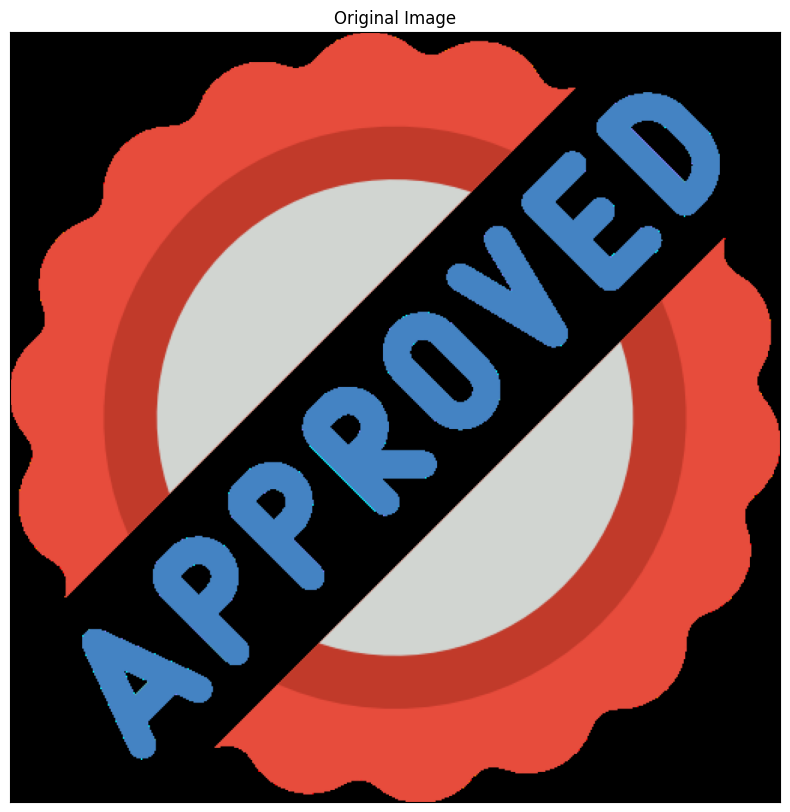

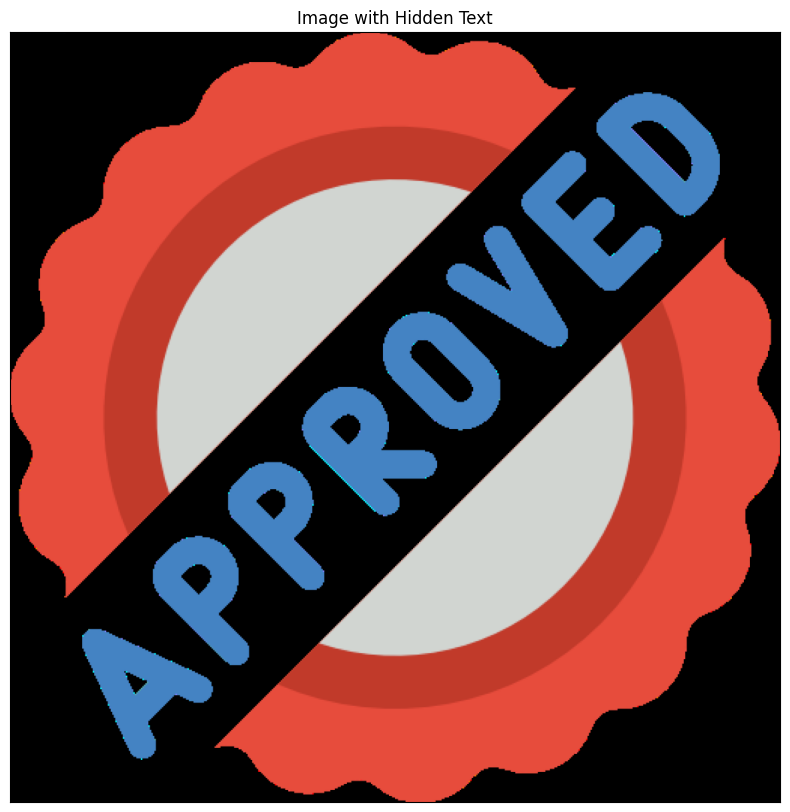

Total time taken for Insert operation: 1.21s


In [6]:
insert_text(img_file,text_file,output_file)

As you can see above, it is hard for the human eye to distinguish between the original and the merged image containing the text hidden inside.

Next, we will define a function to extract this hidden text from the image.

This simple function will accept the required inputs, call the extract function which will save the extracted text in the file name that we provided.

In [7]:
def extract_text(imfile, txtfile, visualize, visfile):
    start_time = time.time()
    ret_val = Steganography.extract(imfile,txtfile,visualize,visfile,debugMode)
    end_time = time.time()
    
    if not ret_val:
      print("!! Extraction Failure !!")
    else:
      print("Total time taken for extraction: {:0.02f}s".format(end_time-start_time))

We will configure our input parameters as before, providing the input image and output text file along with some parameters to control if a visualization video is generated for the extraction process.

Feel free to set true as false if you would prefer to skip the visualization.

In [8]:
new_img_file = 'output.png' # input image file for text extraction
output_txt_file = 'text_output.txt' # output file to store extracted text
visualize = 'true'  # flag to enable/disable visualization
visfile = 'visualize.gif' # file to store visualization video

All we need to do now is call the extract_text function with our configuration parameters

In [9]:
import matplotlib

print(matplotlib.__version__)

3.9.0


Begin processing image file... this may take a few minutes


MovieWriter ffmpeg unavailable; using Pillow instead.


Finished processing image file... time taken: 0.29s
Begin saving visualization file... this may take a few minutes
Finished saving visualization file... time taken: 11.73s


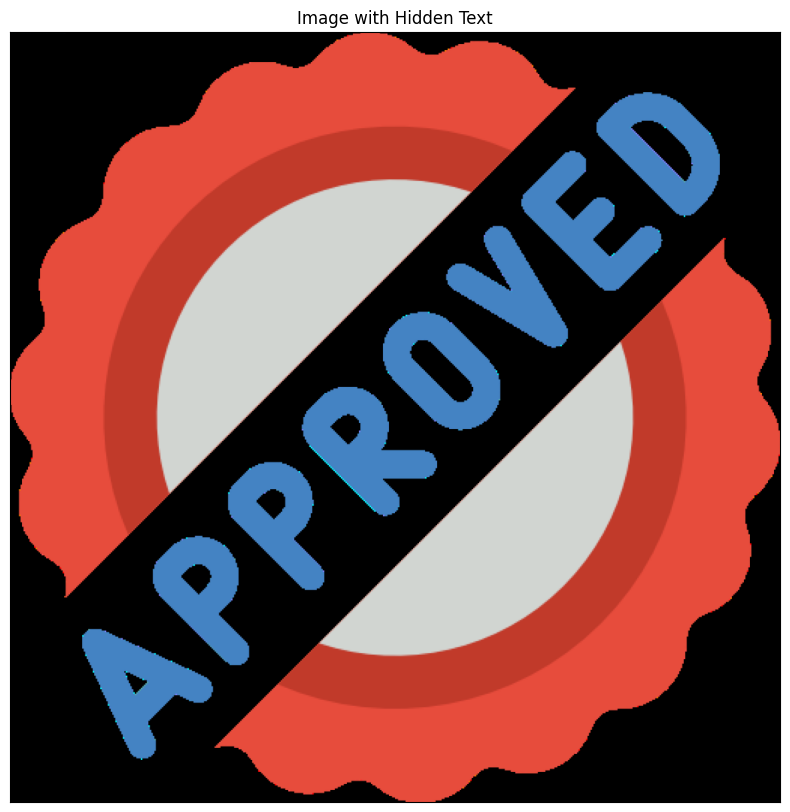

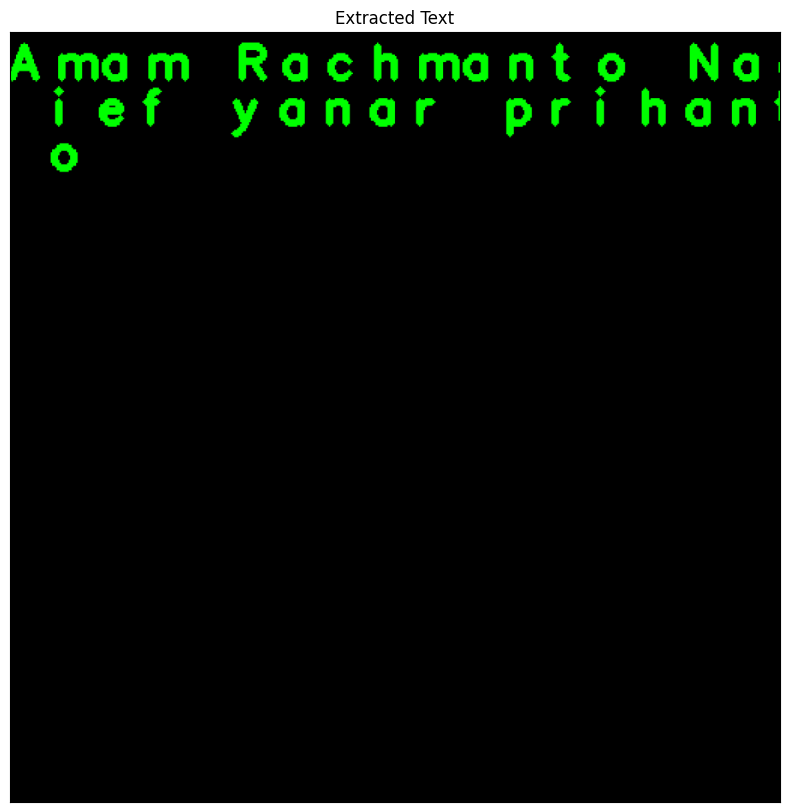

Extracted Text:
Amam Rachmanto Nadief yanar prihanto
Total time taken for extraction: 12.87s


In [10]:
extract_text(new_img_file,output_txt_file,visualize,visfile)

And voila !!

Our hidden text has magically appeared out of the image.

Lets see a visualization of the extraction process.

In [12]:
import cv2
import numpy as np
from scipy.fftpack import dct, idct

def apply_dct(image):
    # Apply DCT to each channel separately
    dct_channels = []
    for i in range(3):  # Assuming image is in BGR format
        channel = image[:, :, i]
        dct_channel = dct(dct(channel.T, norm='ortho').T, norm='ortho')
        dct_channels.append(dct_channel)
    return np.stack(dct_channels, axis=2)

def apply_idct(dct_image):
    # Apply inverse DCT to each channel separately
    idct_channels = []
    for i in range(3):
        dct_channel = dct_image[:, :, i]
        idct_channel = idct(idct(dct_channel.T, norm='ortho').T, norm='ortho')
        idct_channels.append(idct_channel)
    return np.clip(np.stack(idct_channels, axis=2), 0, 255).astype(np.uint8)

# Load the image with hidden text (watermark)
image_path = 'E:/Kuliah/Mata Kuliah/SEMESTER 6/Kompresi data/UAS/stegano/output.png'  # Replace with your image path
image = cv2.imread(image_path)

# Apply DCT to the image
dct_image = apply_dct(image)

# Optionally, you can compress the image by zeroing out small DCT coefficients
# For simplicity, we will zero out coefficients with magnitude less than a threshold
threshold = 10  # You can adjust the threshold
compressed_dct_image = dct_image * (np.abs(dct_image) > threshold)

# Apply inverse DCT to get the compressed image
compressed_image = apply_idct(compressed_dct_image)

# Save the compressed image
compressed_image_path = 'hasilKompresi.png'
cv2.imwrite(compressed_image_path, compressed_image)

print(f'Compressed image saved to {compressed_image_path}')


Compressed image saved to hasilKompresi.png
